# Modelo de generación de secuencias basado en tokens por caracter y redes recurrentes

# Imports

In [1]:
import random
import io
import pickle
from pathlib import Path

import os
import platform
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from scipy.special import softmax
#from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Datos

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs


raw_html = urllib.request.urlopen('https://www.textos.info/homero/odisea/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag )
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()


# en article text se encuentra el texto de todo el libro
article_text[:1000]


' háblame, musa, de aquel varón de multiforme ingenio que, después de \r\ndestruir la sacra ciudad de troya, anduvo peregrinando larguísimo \r\ntiempo, vio las poblaciones y conoció las costumbres de muchos hombres y\r\n padeció en su ánimo gran número de trabajos en su navegación por el \r\nponto, en cuanto procuraba salvar su vida y la vuelta de sus compañeros a\r\n la patria. mas ni aun así pudo librarlos, como deseaba, y todos \r\nperecieron por sus propias locuras. ¡insensatos! comiéronse las vacas de\r\n helios, hijo de hiperión; el cual no permitió que les llegara el día \r\ndel regreso. ¡oh diosa, hija de zeus!, cuéntanos aunque no sea más que \r\nuna parte de tales cosas. ya en aquel tiempo los que habían podido escapar de una muerte \r\nhorrorosa estaban en sus hogares, salvos de los peligros de la guerra y \r\ndel mar; y solamente odiseo, que tan gran necesidad sentía de \r\nrestituirse a su patria y ver a su consorte, hallábase detenido en hueca\r\n gruta por calipso, la ni

# Contexto

In [3]:
# seleccionamos el tamaño de contexto
max_context_size = 100

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

# la longitud de vocabulario de caracteres es:
vocab_size = len(chars_vocab)
print(f"{vocab_size=}")

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

vocab_size=59


# Tokenización

In [4]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

# peek
print(tokenized_text[:100])

[42, 34, 35, 46, 51, 57, 15, 31, 47, 42, 15, 1, 22, 57, 47, 42, 19, 31, 42, 57, 9, 1, 31, 51, 42, 16, 57, 45, 18, 29, 42, 19, 31, 42, 15, 1, 51, 5, 33, 11, 23, 45, 15, 31, 42, 33, 29, 36, 31, 29, 33, 23, 42, 9, 1, 31, 47, 42, 19, 31, 22, 13, 1, 38, 22, 42, 19, 31, 42, 28, 26, 19, 31, 22, 5, 45, 1, 33, 45, 42, 51, 57, 42, 22, 57, 3, 45, 57, 42, 3, 33, 1, 19, 57, 19, 42, 19, 31, 42, 5]


# Config

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 1024 #256
num_epochs = 20
patience = 5

# vemos device
f"Using device {device.upper()}"

'Using device CUDA'

# Dataset

In [6]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [7]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [8]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [9]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

X.shape, y.shape

((620996, 100), (620996, 100))

In [10]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long),
                                               torch.tensor(y, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training utils

In [11]:
def prepare_val_data(val_data, max_context_size, vocab_size):
    targets, padded = [], []
    info = []
    count = 0

    for seq in val_data:
        len_seq = len(seq)
        subseq = [seq[:i] for i in range(1, len_seq)]
        targets.extend([seq[i] for i in range(1, len_seq)])

        if len(subseq) != 0:
            arr = np.zeros((len(subseq), max_context_size), dtype=np.int64)
            for j, s in enumerate(subseq):
                # truncar si es más larga
                s = s[-max_context_size:]
                arr[j, -len(s):] = s
            padded.append(arr)
            info.append((count, count + len_seq))
            count += len_seq

    padded = np.vstack(padded)
    return torch.tensor(padded, dtype=torch.long), torch.tensor(targets, dtype=torch.long), info

In [12]:
def compute_perplexity(model, val_inputs, val_targets, batch_size=256):
    model.eval()
    all_log_probs = []
    with torch.no_grad():
        for i in range(0, len(val_inputs), batch_size):
            xb = val_inputs[i:i+batch_size].to(device)
            yb = val_targets[i:i+batch_size].to(device)

            logits = model(xb.unsqueeze(-1))
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            chosen = log_probs[range(len(yb)), yb]
            all_log_probs.extend(chosen.cpu().numpy())

    all_log_probs = np.array(all_log_probs)
    ppl = float(np.exp(-all_log_probs.mean()))
    return ppl

In [13]:
# preparar datos de validación
histories = dict()
criterion = nn.CrossEntropyLoss()
val_inputs, val_targets, val_info = prepare_val_data(tokenized_sentences_val,
                                                     max_context_size=max_context_size,
                                                     vocab_size=vocab_size)

def train_model(model, optimizer, name):
    global histories

    history_ppl = []
    min_score = float("inf")
    patience_counter = 0

    # --- training loop ---
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb.unsqueeze(-1))   # logits: (batch, seq_len, vocab_size)
            loss = criterion(logits.transpose(1, 2), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        current_ppl = compute_perplexity(model, val_inputs, val_targets, batch_size=batch_size)
        history_ppl.append(current_ppl)

        print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - val_ppl: {current_ppl:.4f}")

        # early stopping
        if current_ppl < min_score:
            min_score = current_ppl
            torch.save(model.state_dict(), f"{name}_best_model.pt")
            print("Saved new best model!")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    histories[name] = history_ppl

In [32]:
def plot_histories(subset_names: list[str] | str =[], exclude: list[str] = [], figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)

    # if it's a str, subset is that name
    if isinstance(subset_names, str):
        subset_names = [subset_names]

    # if no subset is given, assume all keys
    if not subset_names:
        subset_names = histories.keys()

    # if excluded, take them out
    subset_names = [elem for elem in subset_names if elem not in exclude]

    for name in subset_names:
        history_ppl = histories[name]
        epoch_count = range(1, len(history_ppl) + 1)
        ax.plot(epoch_count, history_ppl, label=name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Perplexity')
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.show()

# Testeo de arquitecturas

## Modelo simple

In [15]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, n_recurrents=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.RNN(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=n_recurrents,
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len, 1) con índices enteros
        x = x.squeeze(-1).long()                   # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()  # (batch, seq_len, vocab_size)

        out, _ = self.rnn(x)                      # (batch, seq_len, hidden_size)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out                                # logits (sin softmax)

In [16]:
model = RNNModel(vocab_size).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

Epoch 1/20 - loss: 2.1659 - val_ppl: 6.9169
Saved new best model!
Epoch 2/20 - loss: 1.7816 - val_ppl: 5.5266
Saved new best model!
Epoch 3/20 - loss: 1.6188 - val_ppl: 5.0280
Saved new best model!
Epoch 4/20 - loss: 1.5262 - val_ppl: 4.7394
Saved new best model!
Epoch 5/20 - loss: 1.4687 - val_ppl: 4.6055
Saved new best model!
Epoch 6/20 - loss: 1.4295 - val_ppl: 4.4735
Saved new best model!
Epoch 7/20 - loss: 1.4008 - val_ppl: 4.4229
Saved new best model!
Epoch 8/20 - loss: 1.3791 - val_ppl: 4.4134
Saved new best model!
Epoch 9/20 - loss: 1.3616 - val_ppl: 4.3651
Saved new best model!
Epoch 10/20 - loss: 1.3474 - val_ppl: 4.3826
Epoch 11/20 - loss: 1.3359 - val_ppl: 4.3646
Saved new best model!
Epoch 12/20 - loss: 1.3260 - val_ppl: 4.3444
Saved new best model!
Epoch 13/20 - loss: 1.3175 - val_ppl: 4.3616
Epoch 14/20 - loss: 1.3104 - val_ppl: 4.3324
Saved new best model!
Epoch 15/20 - loss: 1.3039 - val_ppl: 4.3178
Saved new best model!
Epoch 16/20 - loss: 1.2984 - val_ppl: 4.3495
Epo

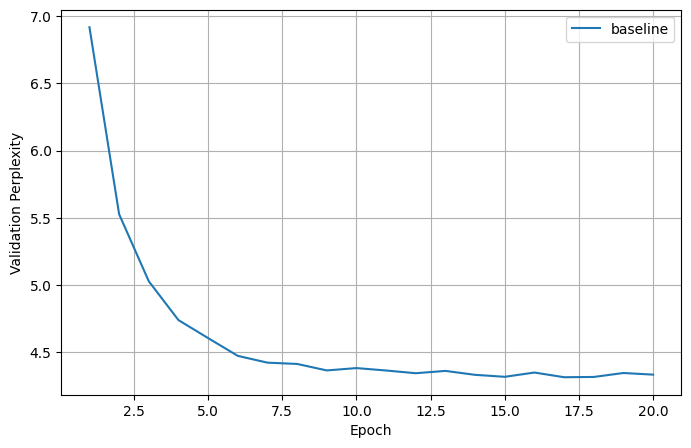

In [17]:
train_model(
    model,
    optimizer,
    'baseline',
)

plot_histories('baseline')

## Modelo con mayor `hidden_size`

In [18]:
model_hd = RNNModel(vocab_size, hidden_size=400).to(device)
optimizer = torch.optim.RMSprop(model_hd.parameters(), lr=0.001)

Epoch 1/20 - loss: 2.2678 - val_ppl: 6.4932
Saved new best model!
Epoch 2/20 - loss: 1.6658 - val_ppl: 4.9599
Saved new best model!
Epoch 3/20 - loss: 1.4396 - val_ppl: 4.5514
Saved new best model!
Epoch 4/20 - loss: 1.3219 - val_ppl: 4.4727
Saved new best model!
Epoch 5/20 - loss: 1.2458 - val_ppl: 4.4949
Epoch 6/20 - loss: 1.1922 - val_ppl: 4.5405
Epoch 7/20 - loss: 1.1536 - val_ppl: 4.6164
Epoch 8/20 - loss: 1.1247 - val_ppl: 4.6612
Epoch 9/20 - loss: 1.1033 - val_ppl: 4.7161
Early stopping triggered


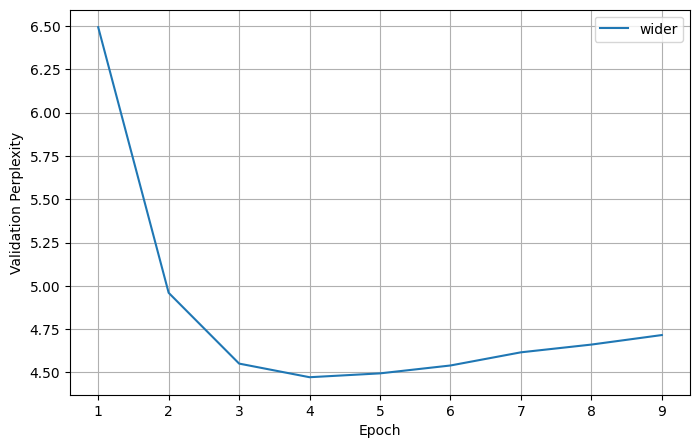

In [19]:
train_model(
    model_hd,
    optimizer,
    'wider',
)

plot_histories('wider')

## Modelo más profundo

In [20]:
model_deeper = RNNModel(vocab_size, n_recurrents=2).to(device)
optimizer = torch.optim.RMSprop(model_deeper.parameters(), lr=0.001)

Epoch 1/20 - loss: 2.0752 - val_ppl: 5.6609
Saved new best model!
Epoch 2/20 - loss: 1.5592 - val_ppl: 4.5248
Saved new best model!
Epoch 3/20 - loss: 1.3869 - val_ppl: 4.1863
Saved new best model!
Epoch 4/20 - loss: 1.3025 - val_ppl: 4.0651
Saved new best model!
Epoch 5/20 - loss: 1.2490 - val_ppl: 4.0580
Saved new best model!
Epoch 6/20 - loss: 1.2101 - val_ppl: 4.0214
Saved new best model!
Epoch 7/20 - loss: 1.1803 - val_ppl: 4.0367
Epoch 8/20 - loss: 1.1564 - val_ppl: 4.0630
Epoch 9/20 - loss: 1.1370 - val_ppl: 4.1606
Epoch 10/20 - loss: 1.1207 - val_ppl: 4.1563
Epoch 11/20 - loss: 1.1071 - val_ppl: 4.1889
Early stopping triggered


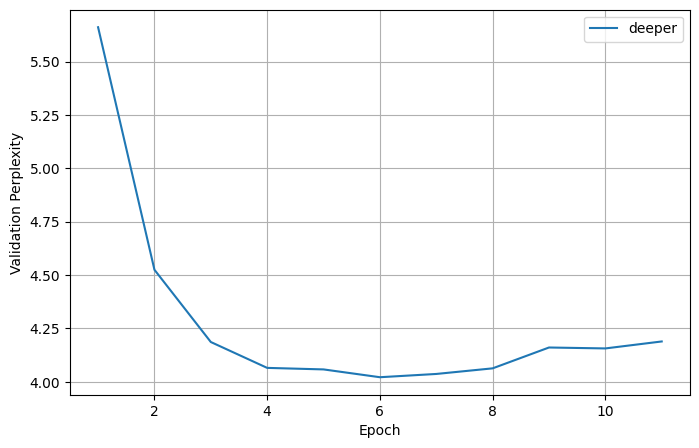

In [21]:
train_model(
    model_deeper,
    optimizer,
    'deeper',
)

plot_histories('deeper')

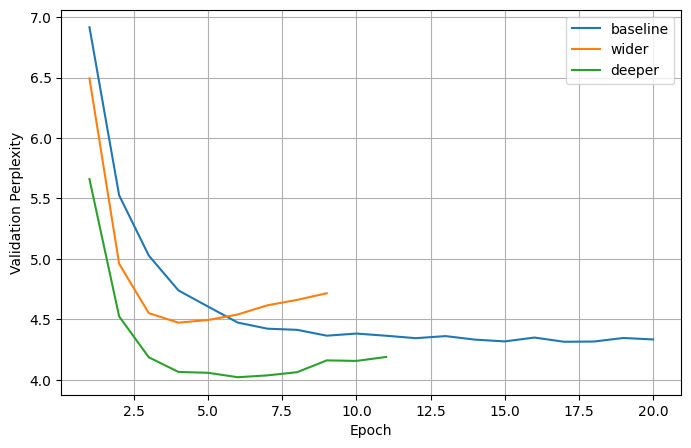

In [22]:
# vemos todas, para comparación
plot_histories()

Observamos que, si bien en pocos epochs empezó a overfittear, el modelo con una capa recurrente extra tiene mejor performance en validación. Basado en los gráficos se explora agregar más complejidad al modelo, pero no por la vía de incrementar el `hidden_size`. Una forma de aumentar la complejidad es utilizar celdas más complejas como LSTM y GRU.

## Modelo con LSTM

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, n_recurrents=1, dropout=0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.LSTM(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=n_recurrents,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len, 1) con índices enteros
        x = x.squeeze(-1).long()                   # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()  # (batch, seq_len, vocab_size)

        out, _ = self.rnn(x)                      # (batch, seq_len, hidden_size)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out                                # logits (sin softmax)

In [25]:
model_lstm_base = LSTMModel(vocab_size).to(device)
optimizer = torch.optim.RMSprop(model_lstm_base.parameters(), lr=0.001)

train_model(
    model_lstm_base,
    optimizer,
    'lstm_base',
)

Epoch 1/20 - loss: 2.1538 - val_ppl: 6.4350
Saved new best model!
Epoch 2/20 - loss: 1.6829 - val_ppl: 5.0073
Saved new best model!
Epoch 3/20 - loss: 1.4560 - val_ppl: 4.4188
Saved new best model!
Epoch 4/20 - loss: 1.3241 - val_ppl: 4.2779
Saved new best model!
Epoch 5/20 - loss: 1.2408 - val_ppl: 4.1830
Saved new best model!
Epoch 6/20 - loss: 1.1820 - val_ppl: 4.1753
Saved new best model!
Epoch 7/20 - loss: 1.1373 - val_ppl: 4.2173
Epoch 8/20 - loss: 1.1018 - val_ppl: 4.3174
Epoch 9/20 - loss: 1.0725 - val_ppl: 4.2966
Epoch 10/20 - loss: 1.0486 - val_ppl: 4.4803
Epoch 11/20 - loss: 1.0286 - val_ppl: 4.6766
Early stopping triggered


In [26]:
model_lstm2 = LSTMModel(vocab_size, n_recurrents=2).to(device)
optimizer = torch.optim.RMSprop(model_lstm2.parameters(), lr=0.001)

train_model(
    model_lstm2,
    optimizer,
    'lstm2',
)

Epoch 1/20 - loss: 2.0899 - val_ppl: 5.2891
Saved new best model!
Epoch 2/20 - loss: 1.4504 - val_ppl: 4.1860
Saved new best model!
Epoch 3/20 - loss: 1.2184 - val_ppl: 3.9089
Saved new best model!
Epoch 4/20 - loss: 1.0833 - val_ppl: 4.1555
Epoch 5/20 - loss: 0.9816 - val_ppl: 4.3923
Epoch 6/20 - loss: 0.9013 - val_ppl: 4.7087
Epoch 7/20 - loss: 0.8354 - val_ppl: 5.0784
Epoch 8/20 - loss: 0.7813 - val_ppl: 5.3473
Early stopping triggered


## Modelo con GRU

In [27]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, n_recurrents=1, dropout=0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.GRU(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=n_recurrents,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len, 1) con índices enteros
        x = x.squeeze(-1).long()                   # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()  # (batch, seq_len, vocab_size)

        out, _ = self.rnn(x)                      # (batch, seq_len, hidden_size)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out                                # logits (sin softmax)

In [28]:
model_gru_base = GRUModel(vocab_size).to(device)
optimizer = torch.optim.RMSprop(model_gru_base.parameters(), lr=0.001)

train_model(
    model_gru_base,
    optimizer,
    'gru_base',
)

Epoch 1/20 - loss: 2.0901 - val_ppl: 5.9046
Saved new best model!
Epoch 2/20 - loss: 1.5955 - val_ppl: 4.5120
Saved new best model!
Epoch 3/20 - loss: 1.3855 - val_ppl: 4.0922
Saved new best model!
Epoch 4/20 - loss: 1.2824 - val_ppl: 3.9575
Saved new best model!
Epoch 5/20 - loss: 1.2198 - val_ppl: 4.0076
Epoch 6/20 - loss: 1.1762 - val_ppl: 4.1356
Epoch 7/20 - loss: 1.1433 - val_ppl: 4.1261
Epoch 8/20 - loss: 1.1171 - val_ppl: 4.2272
Epoch 9/20 - loss: 1.0963 - val_ppl: 4.3136
Early stopping triggered


In [30]:
model_gru2 = GRUModel(vocab_size, n_recurrents=2).to(device)
optimizer = torch.optim.RMSprop(model_gru2.parameters(), lr=0.001)

train_model(
    model_gru2,
    optimizer,
    'gru2',
)

Epoch 1/20 - loss: 1.9059 - val_ppl: 34.8174
Saved new best model!
Epoch 2/20 - loss: 1.3686 - val_ppl: 31.2221
Saved new best model!
Epoch 3/20 - loss: 1.1980 - val_ppl: 24.6392
Saved new best model!
Epoch 4/20 - loss: 1.1012 - val_ppl: 31.2010
Epoch 5/20 - loss: 1.0308 - val_ppl: 13.6608
Saved new best model!
Epoch 6/20 - loss: 0.9751 - val_ppl: 9.9200
Saved new best model!
Epoch 7/20 - loss: 0.9300 - val_ppl: 10.4690
Epoch 8/20 - loss: 0.8931 - val_ppl: 10.2099
Epoch 9/20 - loss: 0.8626 - val_ppl: 8.7117
Saved new best model!
Epoch 10/20 - loss: 0.8373 - val_ppl: 8.4211
Saved new best model!
Epoch 11/20 - loss: 0.8159 - val_ppl: 12.0577
Epoch 12/20 - loss: 0.7978 - val_ppl: 10.0889
Epoch 13/20 - loss: 0.7820 - val_ppl: 13.4587
Epoch 14/20 - loss: 0.7685 - val_ppl: 9.6150
Epoch 15/20 - loss: 0.7567 - val_ppl: 8.5690
Early stopping triggered


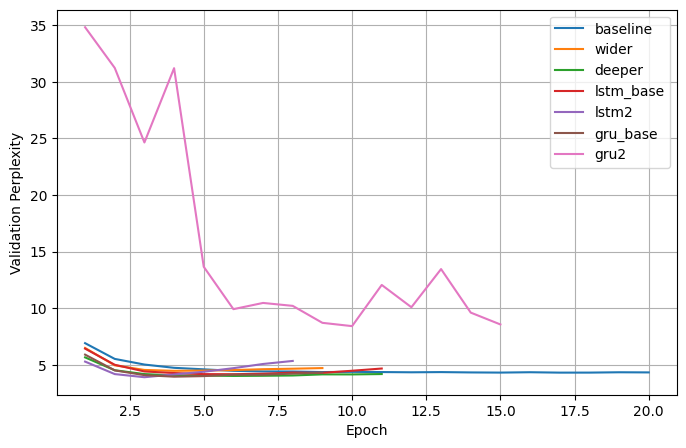

In [31]:
# volvemos a mirar todos juntos
plot_histories()

El error tan elevado de la variante GRUx2 distorsiona todo, la descartamos

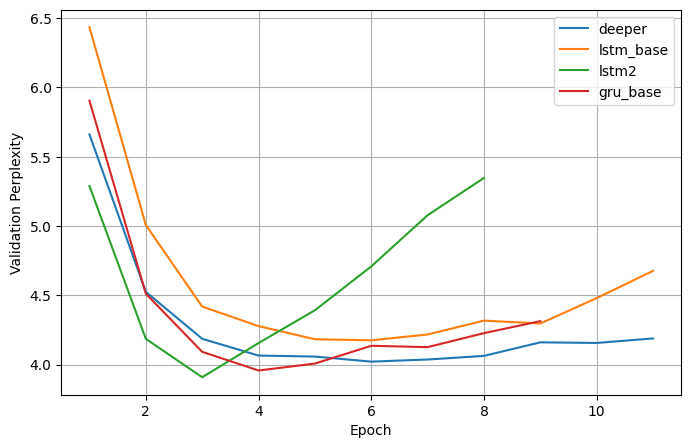

In [34]:
# ya que etamos sacamos también wider y baseline
plot_histories(exclude=['gru2','wider','baseline'])

Evidentemente aumentar la complejidad del modelo es una vía prometedora, pero hay que aplicar algo de regularización para no caer en overfitting.

Resulta interesante ver que una capa de GRU tiene casi el mismo óptimo que dos capas de LSTM.

## GRU con regularización y múltiples capas

Epoch 1/20 - loss: 1.9459 - val_ppl: 15.4607
Saved new best model!
Epoch 2/20 - loss: 1.4323 - val_ppl: 5.9930
Saved new best model!
Epoch 3/20 - loss: 1.2945 - val_ppl: 4.6357
Saved new best model!
Epoch 4/20 - loss: 1.2258 - val_ppl: 3.8474
Saved new best model!
Epoch 5/20 - loss: 1.1803 - val_ppl: 3.7080
Saved new best model!
Epoch 6/20 - loss: 1.1461 - val_ppl: 3.7411
Epoch 7/20 - loss: 1.1187 - val_ppl: 3.8449
Epoch 8/20 - loss: 1.0961 - val_ppl: 3.9388
Epoch 9/20 - loss: 1.0774 - val_ppl: 4.1486
Epoch 10/20 - loss: 1.0618 - val_ppl: 4.0812
Early stopping triggered


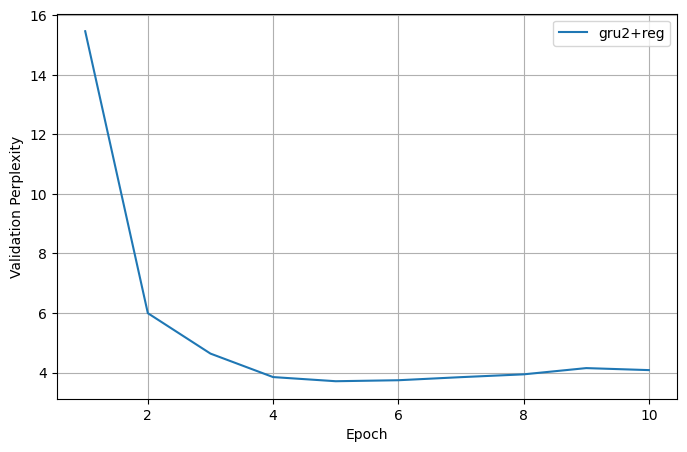

In [35]:
model_gru2_reg = GRUModel(vocab_size, n_recurrents=2, dropout=0.3).to(device)
optimizer = torch.optim.RMSprop(model_gru2_reg.parameters(), lr=0.001)

train_model(
    model_gru2_reg,
    optimizer,
    'gru2+reg',
)

Epoch 1/20 - loss: 1.9667 - val_ppl: 5.9572
Saved new best model!
Epoch 2/20 - loss: 1.4756 - val_ppl: 4.4972
Saved new best model!
Epoch 3/20 - loss: 1.3490 - val_ppl: 4.0879
Saved new best model!
Epoch 4/20 - loss: 1.2866 - val_ppl: 3.9594
Saved new best model!
Epoch 5/20 - loss: 1.2468 - val_ppl: 3.8935
Saved new best model!
Epoch 6/20 - loss: 1.2179 - val_ppl: 3.8385
Saved new best model!
Epoch 7/20 - loss: 1.1950 - val_ppl: 3.7538
Saved new best model!
Epoch 8/20 - loss: 1.1764 - val_ppl: 3.7052
Saved new best model!
Epoch 9/20 - loss: 1.1605 - val_ppl: 3.6388
Saved new best model!
Epoch 10/20 - loss: 1.1468 - val_ppl: 3.6576
Epoch 11/20 - loss: 1.1350 - val_ppl: 3.6348
Saved new best model!
Epoch 12/20 - loss: 1.1243 - val_ppl: 3.6589
Epoch 13/20 - loss: 1.1151 - val_ppl: 3.6012
Saved new best model!
Epoch 14/20 - loss: 1.1068 - val_ppl: 3.6150
Epoch 15/20 - loss: 1.0994 - val_ppl: 3.6230
Epoch 16/20 - loss: 1.0929 - val_ppl: 3.6264
Epoch 17/20 - loss: 1.0871 - val_ppl: 3.6187
Ep

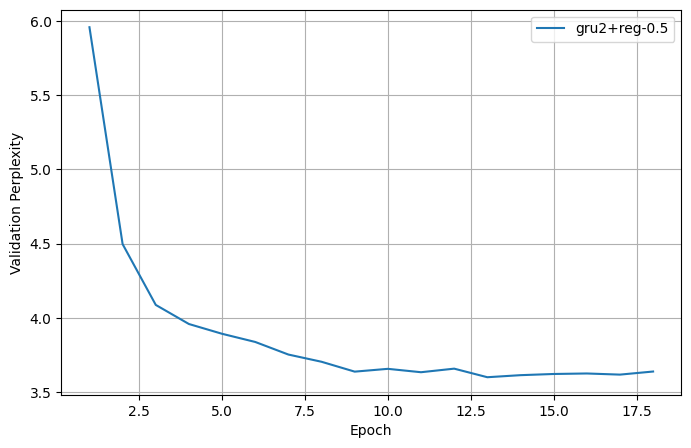

In [36]:
model_gru2_regb = GRUModel(vocab_size, n_recurrents=2, dropout=0.5).to(device)
optimizer = torch.optim.RMSprop(model_gru2_regb.parameters(), lr=0.001)

train_model(
    model_gru2_regb,
    optimizer,
    'gru2+reg-0.5',
)

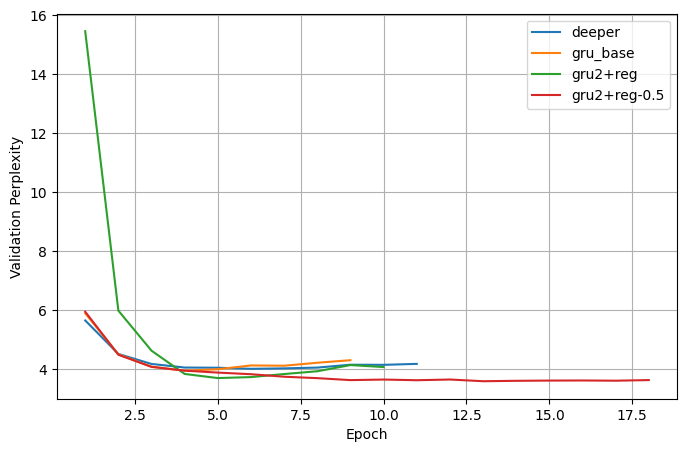

In [38]:
plot_histories(['deeper','gru_base','gru2+reg','gru2+reg-0.5'])

GRU con regularización parece ser una buena opción, agregamos más capas y mantenemos regularización.

In [39]:
model_gru3 = GRUModel(vocab_size, n_recurrents=3, dropout=0.5).to(device)
optimizer = torch.optim.RMSprop(model_gru3.parameters(), lr=0.001)

train_model(
    model_gru3,
    optimizer,
    'gru3',
)

Epoch 1/20 - loss: 2.0143 - val_ppl: 4.9339
Saved new best model!
Epoch 2/20 - loss: 1.5130 - val_ppl: 4.0831
Saved new best model!
Epoch 3/20 - loss: 1.3836 - val_ppl: 3.7496
Saved new best model!
Epoch 4/20 - loss: 1.3220 - val_ppl: 3.6543
Saved new best model!
Epoch 5/20 - loss: 1.2834 - val_ppl: 3.5627
Saved new best model!
Epoch 6/20 - loss: 1.2564 - val_ppl: 3.5324
Saved new best model!
Epoch 7/20 - loss: 1.2362 - val_ppl: 3.5162
Saved new best model!
Epoch 8/20 - loss: 1.2200 - val_ppl: 3.4957
Saved new best model!
Epoch 9/20 - loss: 1.2066 - val_ppl: 3.5056
Epoch 10/20 - loss: 1.1954 - val_ppl: 3.4866
Saved new best model!
Epoch 11/20 - loss: 1.1853 - val_ppl: 3.4818
Saved new best model!
Epoch 12/20 - loss: 1.1769 - val_ppl: 3.4712
Saved new best model!
Epoch 13/20 - loss: 1.1690 - val_ppl: 3.4563
Saved new best model!
Epoch 14/20 - loss: 1.1620 - val_ppl: 3.4173
Saved new best model!
Epoch 15/20 - loss: 1.1555 - val_ppl: 3.4275
Epoch 16/20 - loss: 1.1494 - val_ppl: 3.4682
Epo

In [40]:
# tratamos de forzar overfitting
model_gru6 = GRUModel(vocab_size, n_recurrents=6, dropout=0.5).to(device)
optimizer = torch.optim.RMSprop(model_gru6.parameters(), lr=0.001)

train_model(
    model_gru6,
    optimizer,
    'gru6',
)

Epoch 1/20 - loss: 2.7643 - val_ppl: 9.7999
Saved new best model!
Epoch 2/20 - loss: 2.0968 - val_ppl: 6.3175
Saved new best model!
Epoch 3/20 - loss: 1.7538 - val_ppl: 4.8291
Saved new best model!
Epoch 4/20 - loss: 1.5737 - val_ppl: 4.3332
Saved new best model!
Epoch 5/20 - loss: 1.4763 - val_ppl: 4.0586
Saved new best model!
Epoch 6/20 - loss: 1.4191 - val_ppl: 3.9187
Saved new best model!
Epoch 7/20 - loss: 1.3759 - val_ppl: 3.8182
Saved new best model!
Epoch 8/20 - loss: 1.3456 - val_ppl: 3.7613
Saved new best model!
Epoch 9/20 - loss: 1.3220 - val_ppl: 3.6779
Saved new best model!
Epoch 10/20 - loss: 1.3028 - val_ppl: 3.7015
Epoch 11/20 - loss: 1.2869 - val_ppl: 3.6292
Saved new best model!
Epoch 12/20 - loss: 1.2735 - val_ppl: 3.6583
Epoch 13/20 - loss: 1.2619 - val_ppl: 3.6256
Saved new best model!
Epoch 14/20 - loss: 1.2518 - val_ppl: 3.5912
Saved new best model!
Epoch 15/20 - loss: 1.2428 - val_ppl: 3.5809
Saved new best model!
Epoch 16/20 - loss: 1.2351 - val_ppl: 3.5666
Sav

Como los últimos runs ya tomaron 45 y 90 minutos respectivamente, cortamos acá la experimentación y nos quedamos con los mejores.

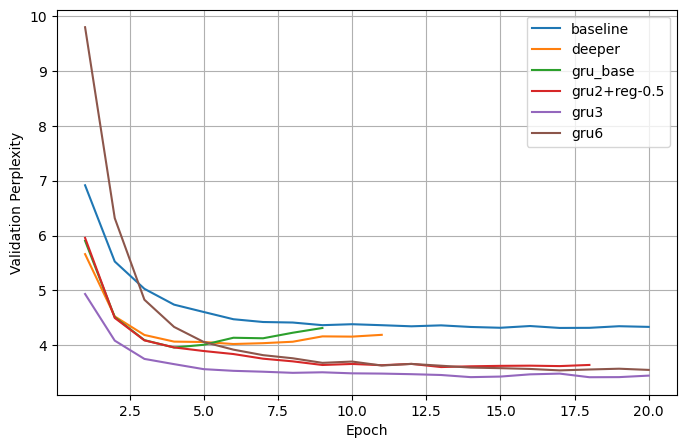

In [47]:
# mostramos cómo fueron mejorando las curvas
plot_histories(['baseline','deeper','gru_base','gru2+reg-0.5','gru3','gru6'])

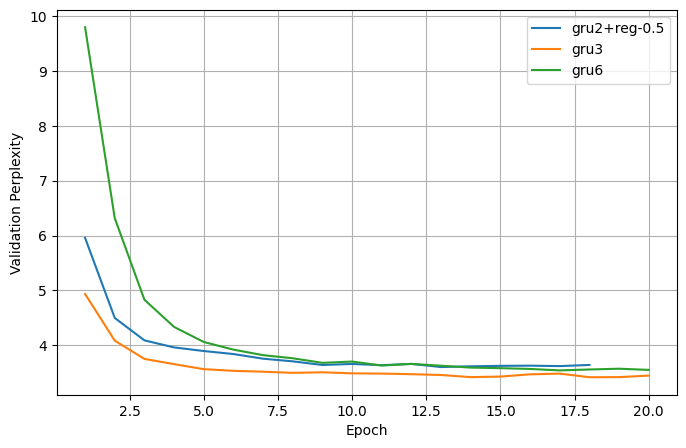

In [49]:
# mostramos sólo los últimos
plot_histories(['gru2+reg-0.5','gru3','gru6'])

Decidimos quedarnos con el GRU de 3 capas, aunque pareciera que el de 6 lo hubiera superado con más epochs.

In [50]:
model = GRUModel(vocab_size, n_recurrents=3, dropout=0.5)
model.load_state_dict(torch.load('gru3_best_model.pt',weights_only=True))
model.to(device)

GRUModel(
  (rnn): GRU(59, 200, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=200, out_features=59, bias=True)
)

# Generación de secuencias

## Utils

Tomados de [la consigna](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_4/ejercicios/4_modelo_lenguaje_char_Pytorch.ipynb)

In [51]:
def encode(text, max_length=max_context_size, device=None):
    # convertir cada caracter a índice (si no está en vocabulario, usar 0)
    encoded = [char2idx.get(ch, 0) for ch in text.lower()]

    # truncar o padear
    if len(encoded) > max_length:
        encoded = encoded[-max_length:]
    else:
        encoded = [0] * (max_length - len(encoded)) + encoded

    # convertir a tensor (batch=1, seq_len, 1)
    tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1)

    if device is not None:
        tensor = tensor.to(device)
    return tensor


def decode(seq):
    if torch.is_tensor(seq):
        seq = seq.cpu().numpy().tolist()
    return ''.join([idx2char[ch] for ch in seq])

In [52]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []

    for idx, pp in enumerate(pred):
        # sumamos los log probs acumulados
        pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]  # beam search determinista
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]),
            num_beams,
            p=softmax(pred_large / temp)
        )
    else:
        raise ValueError(f"Wrong selection mode: {mode}. Use 'det' or 'sto'.")

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words, input_text, max_length,temp=1.0, mode='det'):
    model.eval()
    device = next(model.parameters()).device

    encoded = encode(input_text, max_length=max_length, device=device)  # (1, seq_len, 1)

    with torch.no_grad():
        logits = model(encoded)  # (1, seq_len, vocab_size)
        probs = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

    vocab_size = probs.shape[0]

    history_probs = [0] * num_beams
    history_tokens = [encoded.squeeze(-1).cpu().numpy()[0]] * num_beams  # shape: (seq_len,)

    # seleccionar primeros candidatos
    history_probs, history_tokens = select_candidates([probs],
                                                      num_beams,
                                                      vocab_size,
                                                      history_probs,
                                                      history_tokens,
                                                      temp,
                                                      mode)

    #loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            # mantener contexto de tamaño max_length
            input_update = hist[-max_length:]
            x = torch.tensor(input_update, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

            with torch.no_grad():
                logits = model(x)
                y_hat = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds,
                                                          num_beams,
                                                          vocab_size,
                                                          history_probs,
                                                          history_tokens,
                                                          temp,
                                                          mode)

    # devolver secuencias generadas (últimos tokens relevantes)
    return history_tokens[:, -(len(input_text) + num_words):]

In [64]:
start_text = 'Finalmente, '

## Greedy

Equivalente a hacer beam search determinístico con 1 beam.

In [77]:
salida = beam_search(model,1,200,start_text,max_length=max_context_size,temp=1,mode='det')

print(decode(salida[0]))

finalmente, pues en la 
comida y la casa de la casa de la casa de la casa de la casa de 
la casa de la casa de la casa de la casa de la casa de la casa de 
la casa de la casa de la casa de la casa de la casa d


Como era de esperarse, produce repeticiones de palabras comunes. Si este fenómeno es observable en tokens a nivel de sub-palabra, lo es aún más a nivel de caracter.

## Beam Search

### Determinístico

In [76]:
salidas = beam_search(model,5,200,start_text,max_length=max_context_size,temp=1,mode='det')

for salida in salidas:
    print(decode(salida), end='\n\n')

finalmente, porque los 
compañeros de los demás hombres se hallaban en el palacio. así se expresó; y entonces les dijo estas aladas palabras: —¡oh, circe! ¿quién eres de los hombres que hayas vistosamente 
con 

finalmente, porque los 
compañeros de los demás hombres se hallaban en el palacio. así se expresó; y entonces les dijo estas aladas palabras: —¡oh, circe! ¿quién eres de los hombres que hayas vistosamente 
algu

finalmente, porque los 
compañeros de los demás hombres se hallaban en el palacio. así se expresó; y entonces les dijo estas aladas palabras: —¡oh, circe! ¿quién eres de los dioses que hayas vistosamente 
en el

finalmente, porque los 
compañeros de los demás hombres se hallaban en el palacio. así se expresó; y entonces les dijo estas aladas palabras: —¡oh, circe! ¿quién eres de los dioses que hayas vistosamente 
con e

finalmente, porque los 
compañeros de los demás hombres se hallaban en el palacio. así se expresó; y entonces les dijo estas aladas palabras: —¡oh, circ

Si bien no es coherente en forma "global", sí lo es "localmente". Esto es, fragmentos de la generación son completamente coherentes.

### Estocástico

Primero con temperatura 1.

In [78]:
salidas = beam_search(model,5,200,start_text,max_length=max_context_size,temp=1,mode='sto')

for salida in salidas:
    print(decode(salida), end='\n\n')

finalmente, porque nos 
serían los dioses que en la divina entre las diosas que en el suelo de los 
hombres. v. 112 respondióle el ingenioso odiseo: —¡oh dioses! ¡cuán pretendientes los dioses no tengan por sus

finalmente, porque nos 
serían los dioses que en la divina entre las diosas que en el suelo de los 
hombres. v. 112 respondióle el ingenioso odiseo: —¡oh dioses! ¡cuán pretendientes los dioses no tengan por el 

finalmente, porque nos 
serían los dioses que en la divina entre las diosas que en el suelo de los 
hombres. v. 112 respondióle el ingenioso odiseo: —¡oh dioses! ¡cuán pretendientes los dioses no tengan por su 

finalmente, porque nos 
serían los dioses que en la divina entre las diosas que en el suelo de los 
hombres. v. 112 respondióle el ingenioso odiseo: —¡oh dioses! ¡cuán pretendientes los dioses no tengan por el 

finalmente, porque nos 
serían los dioses que en la divina entre las diosas que en el suelo de los 
hombres. v. 112 respondióle el ingenioso odiseo: —¡o

Bajamos más la temperatura.

In [79]:
salidas = beam_search(model,5,200,start_text,max_length=max_context_size,temp=0.1,mode='sto')

for salida in salidas:
    print(decode(salida), end='\n\n')

finalmente, pues en la 
comida y los dioses no se lo conduzcan por el palacio. así dijo. entonces la divina entre las diosas: —¡oh, amigos! no te después que se hallan en el palacio de la 
casa, porque no te co

finalmente, pues en la 
comida y los dioses no se lo conduzcan por el palacio. así dijo. entonces la divina entre las diosas: —¡oh, amigos! no te después que se hallan en el palacio de la 
casa, porque no te co

finalmente, pues en la 
comida y los dioses no se lo conduzcan por el palacio. así dijo. entonces la divina entre las diosas: —¡oh, amigos! no te después que se hallan en el palacio de la 
casa, porque no te co

finalmente, pues en la 
comida y los dioses no se lo conduzcan por el palacio. así dijo. entonces la divina entre las diosas: —¡oh, amigos! no te después que se hallan en el palacio de la 
casa, porque no te co

finalmente, pues en la 
comida y los dioses no se lo conduzcan por el palacio. así dijo. entonces la divina entre las diosas: —¡oh, amigos! no te despué

Vemos que ahora las frases son más coherentes. Por una cuestión de experimentación, probamos con temperatura más alta, aunque se espera que los resultados no tengan sentido.

In [80]:
salidas = beam_search(model,5,200,start_text,max_length=max_context_size,temp=5,mode='sto')

for salida in salidas:
    print(decode(salida), end='\n\n')

finalmente, na invida la ísita doruetarmeleonoanzeas; pués nsouréntúborruecie mári; eglava; y dio clices hiíásl mas un 
cósidóié déndo bajil) juilce;- impachaóndo lustragáz quiaemos -gol todo 
needolinto, lejan

finalmente, na invida la ísita doruetarmeleonoanzeas; pués nsouréntúborruecie mári; eglava; y dio clices hiíásl mas un 
cósidóié déndo bajil) juilce;- impachaóndo lustragáz quiaemos -gol todo 
needolinto, ledbr

finalmente, na invida la ísita doruetarmeleonoanzeas; pués nsouréntúborruecie mári; eglava; y dio clices hiíásl mas un 
cósidóié déndo bajil) juilce;- impachaóndo lustragáz quiaemos -gol todo 
needolinto, nahis

finalmente, na invida la ísita doruetarmeleonoanzeas; pués nsouréntúborruecie mári; eglava; y dio clices hiíásl mas un 
cósidóié déndo bajil) juilce;- impachaóndo lustragáz quiaemos -gol todo 
needolinto, nahiá

finalmente, na invida la ísita doruetarmeleonoanzeas; pués nsouréntúborruecie mári; eglava; y dio clices hiíásl mas un 
cósidóié déndo bajil) juilce;- i

Efectivamente, los textos generados no tienen sentido.

Como conclusión, se logró entrenar un modelo que produce texto parcialmente coherente. Los mejores resultados se lograron con beam search determinístico y estocástico con temperatura de 0.5.